Inspired in: https://playground.tensorflow.org/

In [16]:
using Pkg
Pkg.activate("..")

  Activating environment at `E:\Projects\OCDNN.jl\Project.toml`


In [17]:
using Revise
using OCDNN, Printf, Random, Serialization, Plots

In [18]:
gr()

Plots.GRBackend()

In [19]:
function in_dir(f, path::String)
    current = pwd()
    cd(path)
    f()
    cd(current)
end

in_dir (generic function with 1 method)

In [20]:
Random.seed!(1234)
dataset = build_dataset(N_samples = 50, N_noise = 0);
data, feat = dataset;

In [21]:
N,d = size(data);

In [22]:
idxs = feat .== 1;

In [23]:
Cs = get_color_palette(:tab10, plot_color(:white));

In [24]:
xs = collect(0:0.01:1)
ys = collect(0:0.01:1);

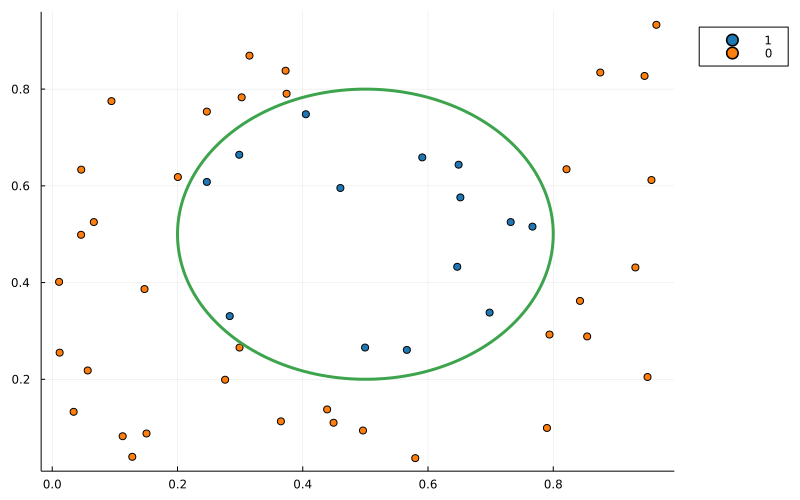

In [25]:
p = Plots.plot(size= (800,500), legend = :outertopright)
Plots.scatter!(p,data[:,1][idxs],data[:,2][idxs], label = "1", c = Cs[1])
Plots.scatter!(p,data[:,1][.!idxs],data[:,2][.!idxs], label = "0", c = Cs[2])
Plots.plot!(p, t->0.3sin(t)+0.5,t->0.3cos(t)+0.5, 0, 2pi, label=false, linewidth=3)

In [54]:
nlayers = 6
channels = 2 # number of neurons per layer
niter = 10000
τ=0.1;
τ_max=10;
h = 0.1
stepsize = 1

1

In [55]:
rks = [RK1,RK2,RK3,RK4];

In [56]:
names = [rk.name for rk in rks];

In [57]:
eta = x -> exp(x)/(exp(x)+1)

#47 (generic function with 1 method)

In [58]:
problem = Problem(tanh, eta, feat);

In [59]:
function cb(iter, rkmethod, nlayers, α, log, Ctrls)
    period = 2000
    if rem(iter,period) == 0 || iter == 1
        @printf("\nMethod=%s, nlayers=%d, channels=%d\n",rkmethod.name,nlayers,Ctrls.channels)
        @printf("Iteration no: %d\n",iter)
        @printf("Value of alpha: %7.4f\n",α);
        @printf("Residual: %8.4f\n",log.loss[end])
        @printf("Norm Grad: %8.4e\n",log.grad_norm[end]);
        @printf("Accuracy: %8.4f %% \n",log.accuracy[end]*100);
        if iter > 1
            @printf("Time: %8.4f\n",sum(log.time[end-period+1:end]));
        end
    end
end

cb (generic function with 1 method)

In [60]:
all_results = [train_ode_dnn(dataset, nlayers, channels, rk, niter, τ, τ_max, h, problem, cb) for rk in rks];


Method=Euler, nlayers=6, channels=2
Iteration no: 1
Value of alpha:  0.0500
Residual:   7.9324
Norm Grad: 4.7135e+00
Accuracy:  44.0000 % 

Method=Euler, nlayers=6, channels=2
Iteration no: 2000
Value of alpha:  0.0500
Residual:   4.7921
Norm Grad: 3.1673e-02
Accuracy:  72.0000 % 
Time:   0.7892

Method=Euler, nlayers=6, channels=2
Iteration no: 4000
Value of alpha:  0.0500
Residual:   4.6481
Norm Grad: 4.6519e-02
Accuracy:  68.0000 % 
Time:   0.5573

Method=Euler, nlayers=6, channels=2
Iteration no: 6000
Value of alpha:  0.0500
Residual:   4.2806
Norm Grad: 6.8817e-02
Accuracy:  66.0000 % 
Time:   0.5833

Method=Euler, nlayers=6, channels=2
Iteration no: 8000
Value of alpha:  0.0500
Residual:   3.7495
Norm Grad: 7.5303e-02
Accuracy:  78.0000 % 
Time:   0.6057

Method=Euler, nlayers=6, channels=2
Iteration no: 10000
Value of alpha:  0.0500
Residual:   3.3108
Norm Grad: 6.2480e-02
Accuracy:  82.0000 % 
Time:   0.5801

Method=RK2, nlayers=6, channels=2
Iteration no: 1
Value of alpha:  0

In [61]:
cd("E:\\Projects\\OCDNN.jl\\notebooks")

In [62]:
final_string = string(nlayers)*"_layers_"*string(N)*"_points_"*string(channels)*"_channels"
traineddir = "..\\train_h\\Classification\\"*final_string*".tmp"
serialize(traineddir, all_results)

In [63]:
final_string = string(nlayers)*"_layers_"*string(N)*"_points_"*string(channels)*"_channels"
outputdir = "..\\images_h\\Classification\\"*final_string
if !isdir(outputdir)
    mkdir(outputdir)
end

In [64]:
all_Ctrls,all_logs = first.(all_results),last.(all_results);

In [65]:
names = ["Euler" "RK2" "RK3" "RK4"]

1×4 Matrix{String}:
 "Euler"  "RK2"  "RK3"  "RK4"

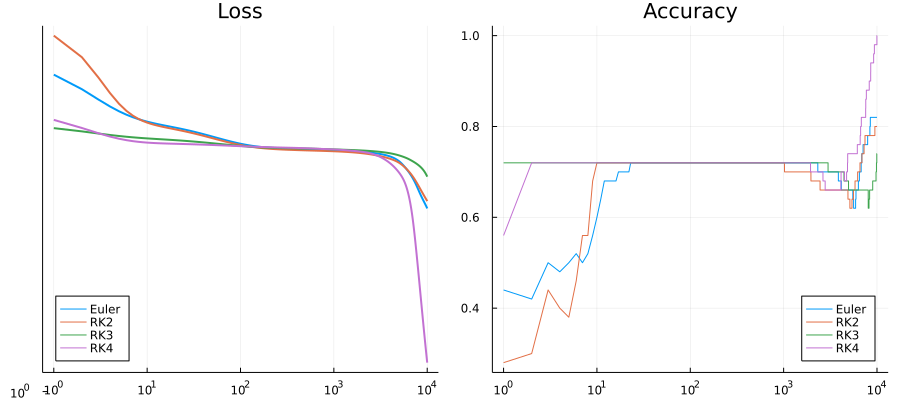

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\rafab\.julia\packages\PlotUtils\VgXdq\src\ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\rafab\.julia\packages\PlotUtils\VgXdq\src\ticks.jl:294


In [70]:
p1 = Plots.plot([all_logs[i].loss for i in 1:4], xaxis = :log10, yaxis = :log10, label = names, linewidth=2, legend= :bottomleft)
p2 = Plots.plot([all_logs[i].accuracy for i in 1:4], xaxis = :log10, label = names, legend= :bottomright)
Plots.plot(p1,p2, title = ["Loss" "Accuracy"], size = (900,400))

In [71]:
in_dir(outputdir) do
    Plots.savefig("loss_acc_hs_"*final_string*".pdf")
end

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\rafab\.julia\packages\PlotUtils\VgXdq\src\ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\rafab\.julia\packages\PlotUtils\VgXdq\src\ticks.jl:294


In [72]:
all_times = [sum(all_logs[i].time) for i in 1:4];

In [73]:
CS = get_color_palette(:auto, plot_color(:white))
all_cs = [CS[i] for i in 1:4];

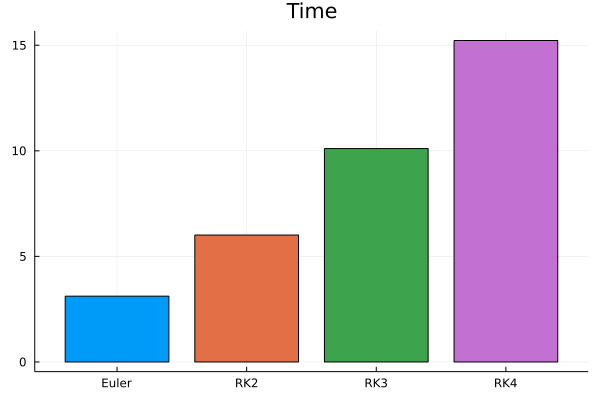

In [89]:
Plots.bar(all_times, xticks = (1:4,names), title = "Time", legend = :none, fillcolor = all_cs)

In [90]:
in_dir(outputdir) do
    Plots.savefig("time_hs_"*final_string*".pdf")
end

In [76]:
all_Ctrls_test = deepcopy.(all_Ctrls);

In [77]:
xs = collect(0:0.002:1)
ys = collect(0:0.002:1);

In [78]:
Y0_test = [[x,y] for x in xs, y in ys];

In [79]:
for i in 1:4
    all_Ctrls_test[i].Y0 = hcat(Y0_test...)';
end

In [80]:
classifiers = [[] for i in 1:4]
for i in 1:4
    classifiers[i] = OCDNN.RKforwardstepper(all_Ctrls_test[i],RK4,problem).Classifier;
end

In [81]:
values = [reshape(round.(classifiers[i]), size(Y0_test))' for i in 1:4];

In [82]:
Cs1 = get_color_palette(:tab10, plot_color(:white));

In [87]:
p = []
for i in 1:4
    pi = Plots.plot(title = names[i], legend = :none, axis = false, ticks = false)
    Plots.contour!(pi,xs,ys, values[i], fill = true, c = [Cs1[2],Cs1[1]])
    Plots.scatter!(pi,data[:,1][idxs],data[:,2][idxs], c = Cs1[1])
    Plots.scatter!(pi,data[:,1][.!idxs],data[:,2][.!idxs], c = Cs1[2])
    Plots.plot!(pi, t->0.3sin(t)+0.5,t->0.3cos(t)+0.5, 0, 2π, legend=false, linewidth=3, c = Cs1[3])
    push!(p,pi)
end
Plots.plot(p..., size=(900,600))

In [88]:
in_dir(outputdir) do
    Plots.savefig("contour_plots_hs_"*final_string*".pdf")
end